In [1]:
from fastai_old.text import *
import html
import spacy 

spacy.load('en')

In [2]:
DATA_PATH=Path('data/')
DATA_PATH.mkdir(exist_ok=True)
#! curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
#! tar -xzfv aclImdb_v1.tar.gz -C {DATA_PATH}

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/')

In [3]:
LM_PATH=Path('data/model_lm/')
LM_PATH.mkdir(exist_ok=True)

In [4]:
CLASSES = ['unsup']
maxn = 60000
component = 'verse' #This is the component of the song to train

def get_texts(path):
    texts = []
    for idx,label in enumerate(CLASSES):
        for fname in (path).glob('*.*'):
            if len(texts) >= maxn:
                break
            texts.append(fname.open('r', encoding='utf-8').read())
    return np.array(texts)

all_texts = get_texts(PATH/component)
len(all_texts)

7907

In [5]:
all_texts[0]

"I woke up this morning in a strange place\nI looked into the mirror at a strange face\nThen I looked for you but you could not be found\nAnd then I felt the lonely coming' down\nI walked across the room to the empty bed\nSaw the imprint on the pillow where you laid your head\nThe presence of you still lingered all around\nAnd once again I felt the lonely coming' down"

In [6]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    all_texts, test_size=0.1)

len(trn_texts), len(val_texts)

(7116, 791)

In [7]:
col_names = ['text']
df_trn = pd.DataFrame({'text':trn_texts}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts}, columns=col_names)

df_trn['text'][0]

"Don't let your eyes get misty now\nWe knew the time would come around for me to go\nI will miss you\nSo long friend, guess I'll see you while ago\nI might be back sometime, you just never know\nI have left a sweetheart north of Whiskey Bay\nTrue love waits down Louisiana way"

In [8]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df):
    texts = f'\n{BOS} {FLD} 1 ' + df['text'].astype(str)
    texts = list(texts.apply(fixup).values)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok

In [9]:
tok_trn = get_texts(df_trn)
tok_val = get_texts(df_val) 

In [10]:
LM_PATH_TMP=Path('data/model_lm/tmp/')
LM_PATH.mkdir(exist_ok=True)

In [11]:
np.save(LM_PATH_TMP/'tok_trn.npy', tok_trn)
np.save(LM_PATH_TMP/'tok_val.npy', tok_val)

In [12]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [13]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(15)

[('\n', 48377),
 ('i', 17306),
 ('the', 15049),
 ('and', 11848),
 ('you', 11408),
 (',', 9824),
 ('a', 9335),
 ('to', 8967),
 ('1', 7122),
 ('xbos', 7116),
 ('xfld', 7116),
 ("'s", 5660),
 ('it', 5543),
 ('in', 5206),
 ('that', 5170)]

In [14]:
max_vocab = 60000
min_freq = 2

In [15]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [16]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

5210

In [17]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [18]:
vs=len(itos)
vs,len(trn_lm)

(5210, 7116)

In [19]:
from pathlib import PosixPath
em_sz,nh,nl = 400,1150,3

PRE_PATH = PosixPath('data/models')
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [20]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

len(itos2)

238462

In [21]:
oov = set(itos) - set(itos2).intersection(itos)
len(oov), list(oov)[0:10]

(119,
 ['ohhh',
  'starin',
  'shinola',
  'prayin',
  'sneakin',
  'crawlin',
  'didli',
  'strenght',
  'sleepin',
  "ma'am"])

In [22]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):                     # for word in imbd vocab
    r = stoi2[w]                                # get the int in the pretrained vocab
    new_w[i] = enc_wgts[r] if r>=0 else row_m   # add weight if in vocab, else add mean weight

In [23]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [24]:
wd=1e-7
bptt=70
bs=32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [26]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

DATA: 14911 70
DATA: 1602 70


In [27]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [28]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.model.load_state_dict(wgts)

INIT <fastai_old.text.LanguageModelData object at 0x7f8efd4d3ef0>


In [29]:
def generate_text(m, s, l=20):
    m[0].bs=1  # Set batch size to 1
    m.eval()  # Turn off dropout
    m.reset()  # Reset hidden state
    m[0].bs=bs  # Put the batch size back to what it was

    ss = s.lower().split()
    si = [stoi[w] for w in ss]
    t = torch.autograd.Variable(torch.cuda.LongTensor(np.array([si])))
    
    res,*_ = m(t)

    print(s,"\n")
    for i in range(l):
        n = res[-1].topk(2)[1]
        n = n[1] if n.data[0]==0 else n[0]
        print(itos[n], end=' ')
        res,*_ = m(n.unsqueeze(0).unsqueeze(0))
    print('...')
    
def generate_text2(m, s, l=20):
    m[0].bs=1  # Set batch size to 1
    m.eval()  # Turn off dropout
    m.reset()  # Reset hidden state
    m[0].bs=bs  # Put the batch size back to what it was

    ss = s.lower().split()
    si = [stoi[w] for w in ss]
    t = torch.autograd.Variable(torch.cuda.LongTensor(np.array([si])))
    
    res,*_ = m(t)

    print(s, end=' ')
    for i in range(l):
        #n = res[-1].topk(5)[1]  # top word
        n = torch.multinomial(res[-1].exp(), 3)  # drawing from probability distribution
        n = n[1] if n.data[0]==0 else n[0]
        print(itos2[int(n)], end=' ')
        res,*_ = m(n.unsqueeze(0).unsqueeze(0))  # sometimes need an extra .unsqueeze(0)
    print('...')
    
def generate_text3(m, s, l=20):
    m[0].bs=1  # Set batch size to 1
    m.eval()  # Turn off dropout
    m.reset()  # Reset hidden state
    m[0].bs=bs  # Put the batch size back to what it was

    ss = s.lower().split()
    si = [stoi[w] for w in ss]
    t = torch.autograd.Variable(torch.cuda.LongTensor(np.array([si])))
    
    res,*_ = m(t)
    
    print(s, end=' ')
    count = 0;
    while True:
        if np.random.choice([0,1], p=[0.05,0.95]) == 0:
            n = res[-1].topk(5)[1]  # top word
        else:
            n = torch.multinomial(res[-1].exp(), 10)  # drawing from probability distribution
        n = n[1] if n.data[0]==0 else n[0]
        if itos[int(n)] == '\n' and count > l:
            print('')
            break
        if not any (x in itos[int(n)] for x in ['xbos', 'xfld']):
            print(itos[int(n)], end=' ')
        res,*_ = m(n.unsqueeze(0).unsqueeze(0))  # sometimes need an extra .unsqueeze(0)
        count += 1

In [30]:
m=learner.model

In [31]:
generate_text2(m, "The")

The hip using by details dan knowledge of chart ny 
 
 . flight due out incident no response platform service - ...


# Training

In [32]:
type(learner)

fastai_old.text.RNN_Learner

In [33]:
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [34]:
lr=1e-3
lrs = lr

In [35]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=5)

using non beta 212 5 <fastai_old.text.LanguageModelLoader object at 0x7f8f9c0eeac8>
SET NB 4


epoch      trn_loss   val_loss   accuracy                   
    0      5.954661   5.908418   0.143068  
    1      5.318378   5.052216   0.171373                   
    2      4.759135   4.424793   0.19949                    
    3      4.525955   4.237737   0.220837                   
    4      4.457291   4.195087   0.227523                   



[4.195087092263358, 0.22752292879990169]

In [36]:
itos_song = itos
with open(PRE_PATH/'itos_song.pkl', 'wb') as f:
    pickle.dump(itos_song, f)
learner.save('lm_last_ft')

In [37]:
learner.load('lm_last_ft')

In [38]:
m=learner.model

In [39]:
generate_text2(m, "the", l=50)

the humans in food from . hip mines by has previously development 
 
 . winter video duties in of . hill french again to working because a game wrestling has if operations by 6 written game $ himself . find by . popular group by . university 
 
 which . 1948 ...


In [40]:
learner.unfreeze()
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                   
    0      4.052816   3.895948   0.289304  



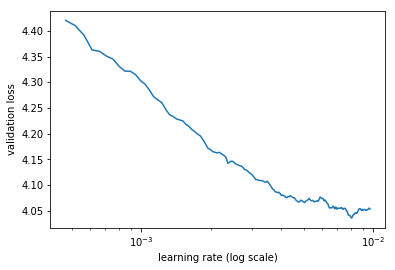

In [41]:
learner.sched.plot()

In [42]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=10)

using non beta 212 10 <fastai_old.text.LanguageModelLoader object at 0x7f8f9c0eeac8>
SET NB 4


epoch      trn_loss   val_loss   accuracy                   
    0      4.011616   3.771245   0.299018  
    1      3.757318   3.645952   0.315786                   
    2      3.546835   3.604402   0.321494                   
    3      3.362818   3.593759   0.326537                   
    4      3.23041    3.582315   0.327105                   
    5      3.110915   3.595227   0.32797                    
    6      2.995333   3.602622   0.329888                   
    7      2.915481   3.622178   0.3319                     
    8      2.841945   3.635538   0.332779                   
    9      2.911568   3.634563   0.332234                   



[3.634562923794701, 0.3322342194262005]

In [43]:
learner.save('lm_3epochs')
m=learner.model
generate_text2(m, "the way it is", l=150)

the way it is . port remix on grand thomas the at alone through events are western director in ; according a t_up home the of off other species a england british series prince 60 ship the " was = he germany british to democratic three on singing the of and through . admiral by he so the - from . great as media episode : the it become follow of follow the be from interview 's . rest the 
 
  from miles 's this which to several ( released the , into 2011 and its that 2011 the of , us off , play the of received , song often season the are in ( caused of deeply the ( york her no the of ( english . goal along the where 
 
  into made 
  the " was = games , him born the be victoria to days the , 3 members ...


In [44]:
num_epochs = 30
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=num_epochs)
learner.save('lm_30epochs-verse-country')

epoch      trn_loss   val_loss   accuracy                   
    0      3.641969   3.822229   0.296906  

using non beta 212 30 <fastai_old.text.LanguageModelLoader object at 0x7f8f9c0eeac8>
SET NB 4


epoch      trn_loss   val_loss   accuracy                   
    0      2.826574   3.633253   0.331421  
    1      2.776166   3.674339   0.327343                   
    2      2.75594    3.705954   0.327042                   
    3      2.703092   3.680138   0.327916                   
    4      2.578305   3.731915   0.325243                   
    5      2.430069   3.823721   0.324597                   
    6      2.319492   3.886437   0.326616                   
    7      2.244771   3.871184   0.323087                   
    8      2.198752   3.90221    0.325722                   
    9      2.061785   3.998779   0.324766                   
    10     1.974166   4.043092   0.327499                   
    11     1.897251   4.088788   0.327236                   
    12     1.93739    4.027738   0.326363                   
    13     1.823599   4.116727   0.326458                   
    14     1.735296   4.224079   0.326302                   
    15     1.647375   4.244336   0.327464

In [45]:
learner.save('lm_30epochs')

In [46]:
m=learner.model
generate_text3(m, "this day they play", l=150)

this day they play the things i know 
 how much i owe it to you and lack me 
 i ca n't believe that it 's all in my mind 
 1 as i sit here , i 'm freezing to death 
 and you 've frozen and cried in my sleep 
 praying to god for his dying 
 and you ask me if i 'll pray , god would pray 
 and throughout the night , i will cry 
 pretend that it 's time to face reality 
 1 we can work it out in the dashboard light 
 it can cool your heart in a soul 
 but it do n't show no brush of your love 
 it 's a line it take to get your body 's blood run cold 
 1 you know the way , it 's a total thrill 


In [47]:
def generate_text3(m, s, l=20):
    m[0].bs=1  # Set batch size to 1
    m.eval()  # Turn off dropout
    m.reset()  # Reset hidden state
    m[0].bs=bs  # Put the batch size back to what it was

    ss = s.lower().split()
    si = [stoi[w] for w in ss]
    t = torch.autograd.Variable(torch.cuda.LongTensor(np.array([si])))
    
    res,*_ = m(t)
    
    print(s, end=' ')
    count = 0;
    while True:
        if np.random.choice([0,1], p=[0.05,0.95]) == 0:
            n = res[-1].topk(5)[1]  # top word
        else:
            n = torch.multinomial(res[-1].exp(), 10)  # drawing from probability distribution
        n = n[1] if n.data[0]==0 else n[0]
        if itos[int(n)] == '\n' and count > l:
            print('')
            break
        if not any (x in itos[int(n)] for x in ['xbos', 'xfld']):
            print(itos[int(n)], end=' ')
        res,*_ = m(n.unsqueeze(0).unsqueeze(0))  # sometimes need an extra .unsqueeze(0)
        count += 1

In [48]:
pickle.dump(itos, open(LM_PATH/'tmp'/'itos-verse-country.pkl', 'wb'))